In [ ]:
! pip install mlxtend

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from mlxtend.frequent_patterns import apriori, association_rules
import warnings


new_data = pd.read_csv('HM-Sales-2018.csv')


In [ ]:
new_data_cleaned = pd.read_csv('HM-Sales-2018.csv')

In [ ]:
print(new_data.columns)


Index(['Order ID', 'Order Date', 'Ship Mode', 'Customer ID', 'Country', 'City',
       'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [ ]:
# Cell 2: Random Forest Regression Optimization


X = new_data.drop('Profit', axis=1)
y = new_data['Profit']

X = X.select_dtypes(exclude=['object'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

best_model_rf.fit(X_train, y_train)
y_pred_rf = best_model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Results:")
print("Mean Squared Error:", mse_rf)
print("Mean Absolute Error:", mae_rf)
print("R-squared (R2) Score:", r2_rf)


Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Regression Results:
Mean Squared Error: 621.5292648512408
Mean Absolute Error: 16.12404478863815
R-squared (R2) Score: 0.1789286483561633


In [ ]:
le = LabelEncoder()
new_data_cleaned['Category'] = le.fit_transform(new_data_cleaned['Category'])
X_ridge = new_data_cleaned[['Category', 'Quantity']]
y_ridge = new_data_cleaned['Profit']
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X_ridge, y_ridge, test_size=0.2, random_state=42)

warnings.filterwarnings("ignore", category=DeprecationWarning)
scaler_ridge = StandardScaler()
X_train_scaled_ridge = scaler_ridge.fit_transform(X_train_ridge)
X_test_scaled_ridge = scaler_ridge.transform(X_test_ridge)

param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_scaled_ridge, y_train_ridge)

best_model_ridge = grid_search_ridge.best_estimator_
print("Best Parameters for Ridge Regression:", grid_search_ridge.best_params_)

ridge_predictions = best_model_ridge.predict(X_test_scaled_ridge)
ridge_mse = mean_squared_error(y_test_ridge, ridge_predictions)
ridge_r2 = r2_score(y_test_ridge, ridge_predictions)

print("Ridge Regression Results:")
print(f"Ridge Regression Coefficients: {best_model_ridge.coef_}")
print(f"Ridge Regression MSE: {ridge_mse}")
print(f"Ridge Regression R2 Score: {ridge_r2}")

Best Parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Results:
Ridge Regression Coefficients: [-42.20648508 -25.34024475]
Ridge Regression MSE: 5006.7082651473675
Ridge Regression R2 Score: -5.614112890621214


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Time Series Forecasting Results:
Time Series MSE: 7256081.388057724
Time Series R2 Score: -0.7854833702247861


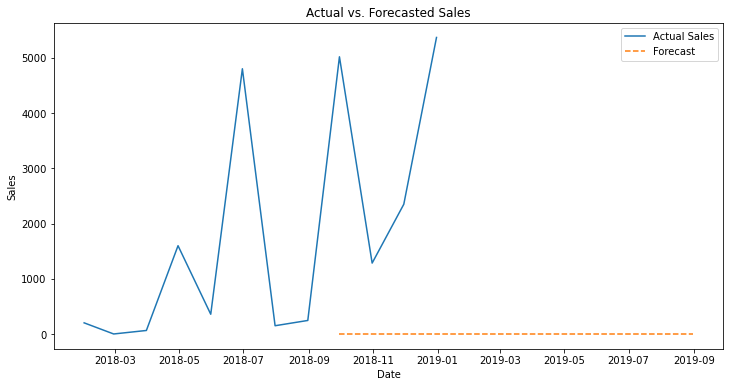

In [ ]:
# Cell 4: Time Series Forecasting

time_series_data = new_data_cleaned[['Order Date', 'Sales', 'Profit']].copy()
time_series_data['Order Date'] = pd.to_datetime(time_series_data['Order Date'])
time_series_data.set_index('Order Date', inplace=True)

model = ExponentialSmoothing(time_series_data['Sales'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

forecast = model_fit.forecast(steps=12)
forecast = pd.Series(forecast, index=pd.date_range(start=time_series_data.index[-1], periods=12, freq='M'))

time_series_data = time_series_data.resample('M').sum()
forecast = forecast.resample('M').sum()

mse_time_series = mean_squared_error(time_series_data['Sales'], forecast)
r2_time_series = r2_score(time_series_data['Sales'], forecast)

print("Time Series Forecasting Results:")
print("Time Series MSE:", mse_time_series)
print("Time Series R2 Score:", r2_time_series)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data['Sales'], label='Actual Sales')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Actual vs. Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


Association Rule Mining Results:
          antecedents                                     consequents  \
0        (Flip flops)                                          (Bags)   
1              (Bags)                                    (Flip flops)   
2     (Heels & Flats)                                          (Bags)   
3              (Bags)                                 (Heels & Flats)   
4           (Jackets)                                          (Bags)   
...               ...                                             ...   
1495          (Belts)  (Tops, Dresses, Jackets, Sport shoes, Formals)   
1496        (Dresses)    (Tops, Belts, Jackets, Sport shoes, Formals)   
1497        (Jackets)    (Belts, Dresses, Tops, Sport shoes, Formals)   
1498    (Sport shoes)        (Tops, Belts, Dresses, Jackets, Formals)   
1499        (Formals)    (Tops, Belts, Dresses, Jackets, Sport shoes)   

      antecedent support  consequent support   support  confidence      lift  \
0         

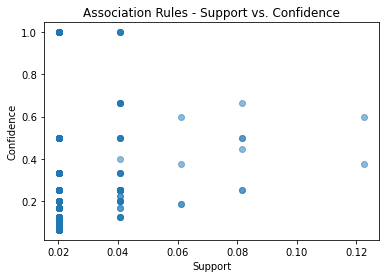

In [ ]:
# Cell 5: Association Rule Mining

df_association = new_data_cleaned[['Order ID', 'Sub-Category']]

basket = df_association.groupby('Order ID')['Sub-Category'].apply(list).reset_index()

basket = basket.set_index('Order ID')['Sub-Category'].str.join('|').str.get_dummies().reset_index()

min_support = 0.005
frequent_itemsets = apriori(basket.drop('Order ID', axis=1), min_support=min_support, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print("Association Rule Mining Results:")
print(rules)

plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules - Support vs. Confidence')
plt.show()
